<a href="https://colab.research.google.com/github/SonuDash/test_codes/blob/SonuDash-patch-1/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Working with Fashion MNIST dataset to predict clothing

*Installing and importing dependencies*

In [197]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [198]:
import tensorflow as tf

In [199]:
#import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [200]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

###Importing the Fashion MNIST dataset

The MNIST dataset is treated as the Hello World of the Machine Learnig programs for computer vision.

In [201]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [202]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


###Exploring the data

In [203]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test exampes:      {}".format(num_test_examples))

Number of training examples: 60000
Number of test exampes:      10000


##Preprocess the data

Here we convert the image data from [0,255] to [0,1] in order for the model to work properly. So here we create a normalization funtion and then apply it to each image in the test and then train the datasets.

In [204]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return  images, labels

"""The map function applies the normalize function to each element in the train
and test datasets""" 
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

""" The first time you use the datasets, the images willbe loaded from disk
caching will keep them in memory, making training faster """
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

###Exloring the processed data

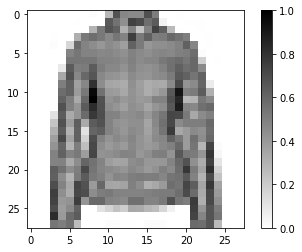

In [205]:
#Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

#Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from training set with their correct class name below. Once achieved we a re good to go!!

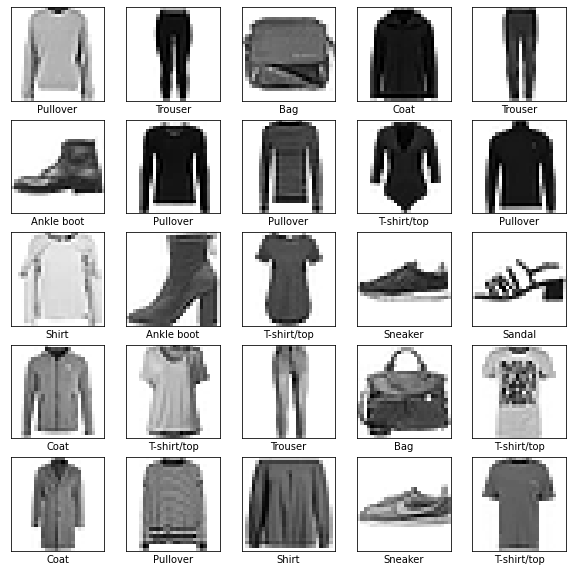

In [206]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image,cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

##Building the model

Building the neural network requires configuring the layers of the model, then compiling th model.

In [207]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

###Compiling the model

These are added during model's compile step:
*  *Loss function*
*  *Optimizer*
* *Metrics*



In [208]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [209]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [210]:
model.fit(train_dataset, epochs=20, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/20
1875/1875 [==============================] - 10s 3ms/step - loss: 0.4748 - accuracy: 0.8312
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3522 - accuracy: 0.8708
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3184 - accuracy: 0.8818
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2961 - accuracy: 0.8918
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2820 - accuracy: 0.8936
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2651 - accuracy: 0.9015
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2527 - accuracy: 0.9054
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2412 - accuracy: 0.9093
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2343 - accuracy: 0.9122
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2

###Evaluating test accuracy

In [211]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset: ',test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3673 - accuracy: 0.8937
Accuracy on test dataset:  0.8937000036239624


##Let's start making prediction on testing set

In [212]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [213]:
predictions.shape

(32, 10)

In [214]:
predictions[2]

array([1.1481796e-13, 2.9770151e-17, 8.0418748e-15, 1.3070970e-17,
       6.0082419e-14, 1.9511430e-02, 7.0147834e-15, 5.5821452e-05,
       9.1862702e-14, 9.8043275e-01], dtype=float32)

In [215]:
np.argmax(predictions[2])

9

In [216]:
test_labels[2]

9

In [217]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]), 
                                       color = color)
  
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

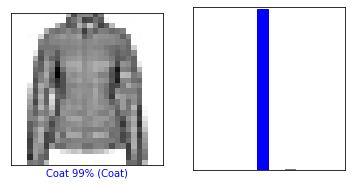

In [218]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

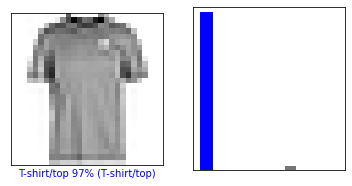

In [219]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

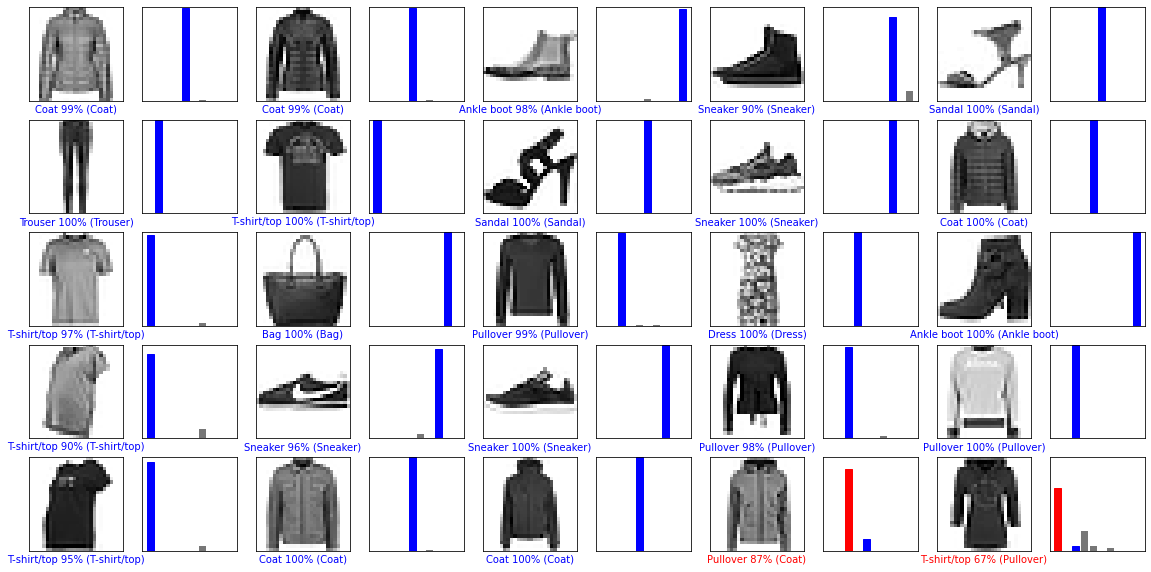

In [220]:
from matplotlib import test
"""Plot the first X test images, their predicted label. and the true label color
correct predictions in blue, incorrect predictions in red"""
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Using the trained model to make prediction about a single image.

In [221]:
# Grab an image from the test dataset
img = test_images[0]

In [222]:
print(img.shape)

(28, 28, 1)


In [223]:
# Add the image to a bath where it's the only member
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [224]:
predictions_single = model.predict(img)
print(predictions_single)

[[4.3789100e-07 7.4003833e-12 1.5133355e-03 2.3820144e-09 9.9177200e-01
  2.3846616e-15 6.7141857e-03 3.2112431e-13 1.0759293e-09 2.6274713e-10]]


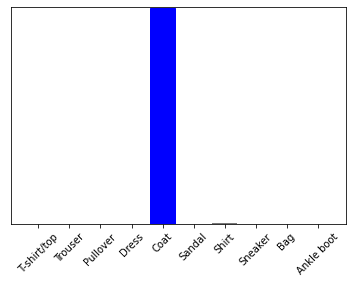

In [225]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation = 45)

In [226]:
np.argmax(predictions_single[0])

4

We can improve the accuracy of our model by increasing the dense layer value or the no. of epochs or by deciding whether or not to normalize the pixels.